### Create linear regression model predicting biomass (clipped) from visual obstruction readings (VOR)

#### Imports

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import ee
import wxee
#import geemap
import xarray as xr
import geopandas as gpd
from rasterio.plot import show
import json
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro, probplot
import pylab 

In [3]:
# authenticate and initialize Earth Engine for extracting gridded PRISM precip
# only need to authenticate every once in a while - will download a temporary
# authorization token
#ee.Authenticate()
wxee.Initialize()

Enter verification code:  4/1Ab_5qlktaByaT8oLFhV4A9inYhfRMscNos4x0w_v2EeukrHBBWHltsGp9Dk



Successfully saved authorization token.


#### Define helper functions

In [4]:
# custom function to get PRISM precip for a single Earth Engine feature
# currently written to get late-year's (lag) water year precip (Oct 1 - Sept. 30, last year)
# and this year's (current) precip up until June 1 (Oct 1 - June 1, this year)
def get_prism_ppt(feature):
    year = ee.Date(feature.get('Date')).get('year')
    prism_lag = ic_prism.filter(ee.Filter.date(ee.Date(year.subtract(2).format().cat('-10-1')),
                                               ee.Date(year.subtract(1).format().cat('-9-30'))))
    ppt_lag = prism_lag.sum().reduceRegion(ee.Reducer.mean(), feature.geometry(), scale=4638.3).get('ppt')
    prism_current = ic_prism.filter(ee.Filter.date(ee.Date(year.subtract(1).format().cat('-10-1')),
                                                   ee.Date(year.format().cat('-6-1'))))
    ppt_current = prism_current.sum().reduceRegion(ee.Reducer.mean(), feature.geometry(), scale=4638.3).get('ppt')
    feature = feature.set('ppt_lag', ppt_lag).set('ppt_current', ppt_current)
    return feature

#### Load inputs

In [5]:
# load all VOR training datasets
df_nex_vor = pd.read_csv('data/vor_train/TB_nex_vor_train.csv', parse_dates=['Date'])
df_gmdr_vor = pd.read_csv('data/vor_train/TB_gmdr_vor_train.csv', parse_dates=['Date'])
df_wtgn_vor = pd.read_csv('data/vor_train/TB_wtgn_vor_train.csv', parse_dates=['Date'])
df_pdog_vor = pd.read_csv('data/vor_train/TB_pdog_vor_train.csv', parse_dates=['Date'])

# load climate data as potential co-variate
# this is downloaded manually from PRISM as a single point, approximately in the center of TB
df_prism = pd.read_csv('data/prism/TB_PRISM_stable_4km_19810101_20220901_43.2929_-105.1229.csv', skiprows=10)

#### Prep data

In [6]:
# give each dataset a name based on the study
df_nex_vor['study'] = 'NEX'
df_gmdr_vor['study'] = 'GMDR'
df_wtgn_vor['study'] = 'WTGN'
df_pdog_vor['study'] = 'PDOG'


# combine all VOR datasets into one
df_vor = pd.concat([df_nex_vor, 
                    df_gmdr_vor, 
                    df_wtgn_vor,
                    df_pdog_vor], axis=0)

# set date on PRISM dataset
df_prism['Date'] = pd.to_datetime(df_prism['Date'])

# convert VOR DataFrame into a GeoDataFrame (for use later when adding gridded PRISM)
gdf_vor = gpd.GeoDataFrame(data=df_vor,
                           geometry=gpd.points_from_xy(df_vor['Mean.GPS_E.Biomass'],
                                                       df_vor['Mean.GPS_N.Biomass']),
                           crs='EPSG:32613')

In [7]:
# give each plot a unique id
df_vor['id_plot'] = df_vor.apply(lambda x: '_'.join([x['Site'], x['Disturbance'], x['Exclosure']]) if x['study'] == 'NEX' else
                                   '_'.join([x['Pasture'], str(int(x['Plot']))]) if x['study'] == 'WTGN' else
                                   '_'.join([str(int(x['Block'])), str(int(x['Paddock']))]) if x['study'] == 'GMDR' else
                                  x['point'], axis=1)
# give each pasture (i.e., block) a name
df_vor['Pasture'] = df_vor.apply(lambda x: x['Pasture'] if x['study'] == 'WTGN' else
                                 x['point'] if x['study'] == 'PDOG' else
                                   x['Site'], axis=1)

In [8]:
# remove spaces from column names
for c in df_vor.columns:
    if ' ' in c:
        df_vor.rename(columns={c: re.sub(' ', '_', c)}, inplace=True)

In [9]:
# calculate the time difference (days) between the VOR and Biomass measurements
df_vor['Date_diff'] = df_vor['Date'] - pd.to_datetime(df_vor['Date_cln'])
df_vor['Date_diff_days'] = df_vor['Date_diff'].dt.days

In [10]:
# create a new dominant functional group class that uses a 60% threshold instead 
# of a 40% threshold
df_vor['domin_fg_2'] = df_vor.apply(lambda x: 'Mixed' if x['domin_fg_pct'] < 0.60 else x['domin_fg'], axis=1)

#### Explore data

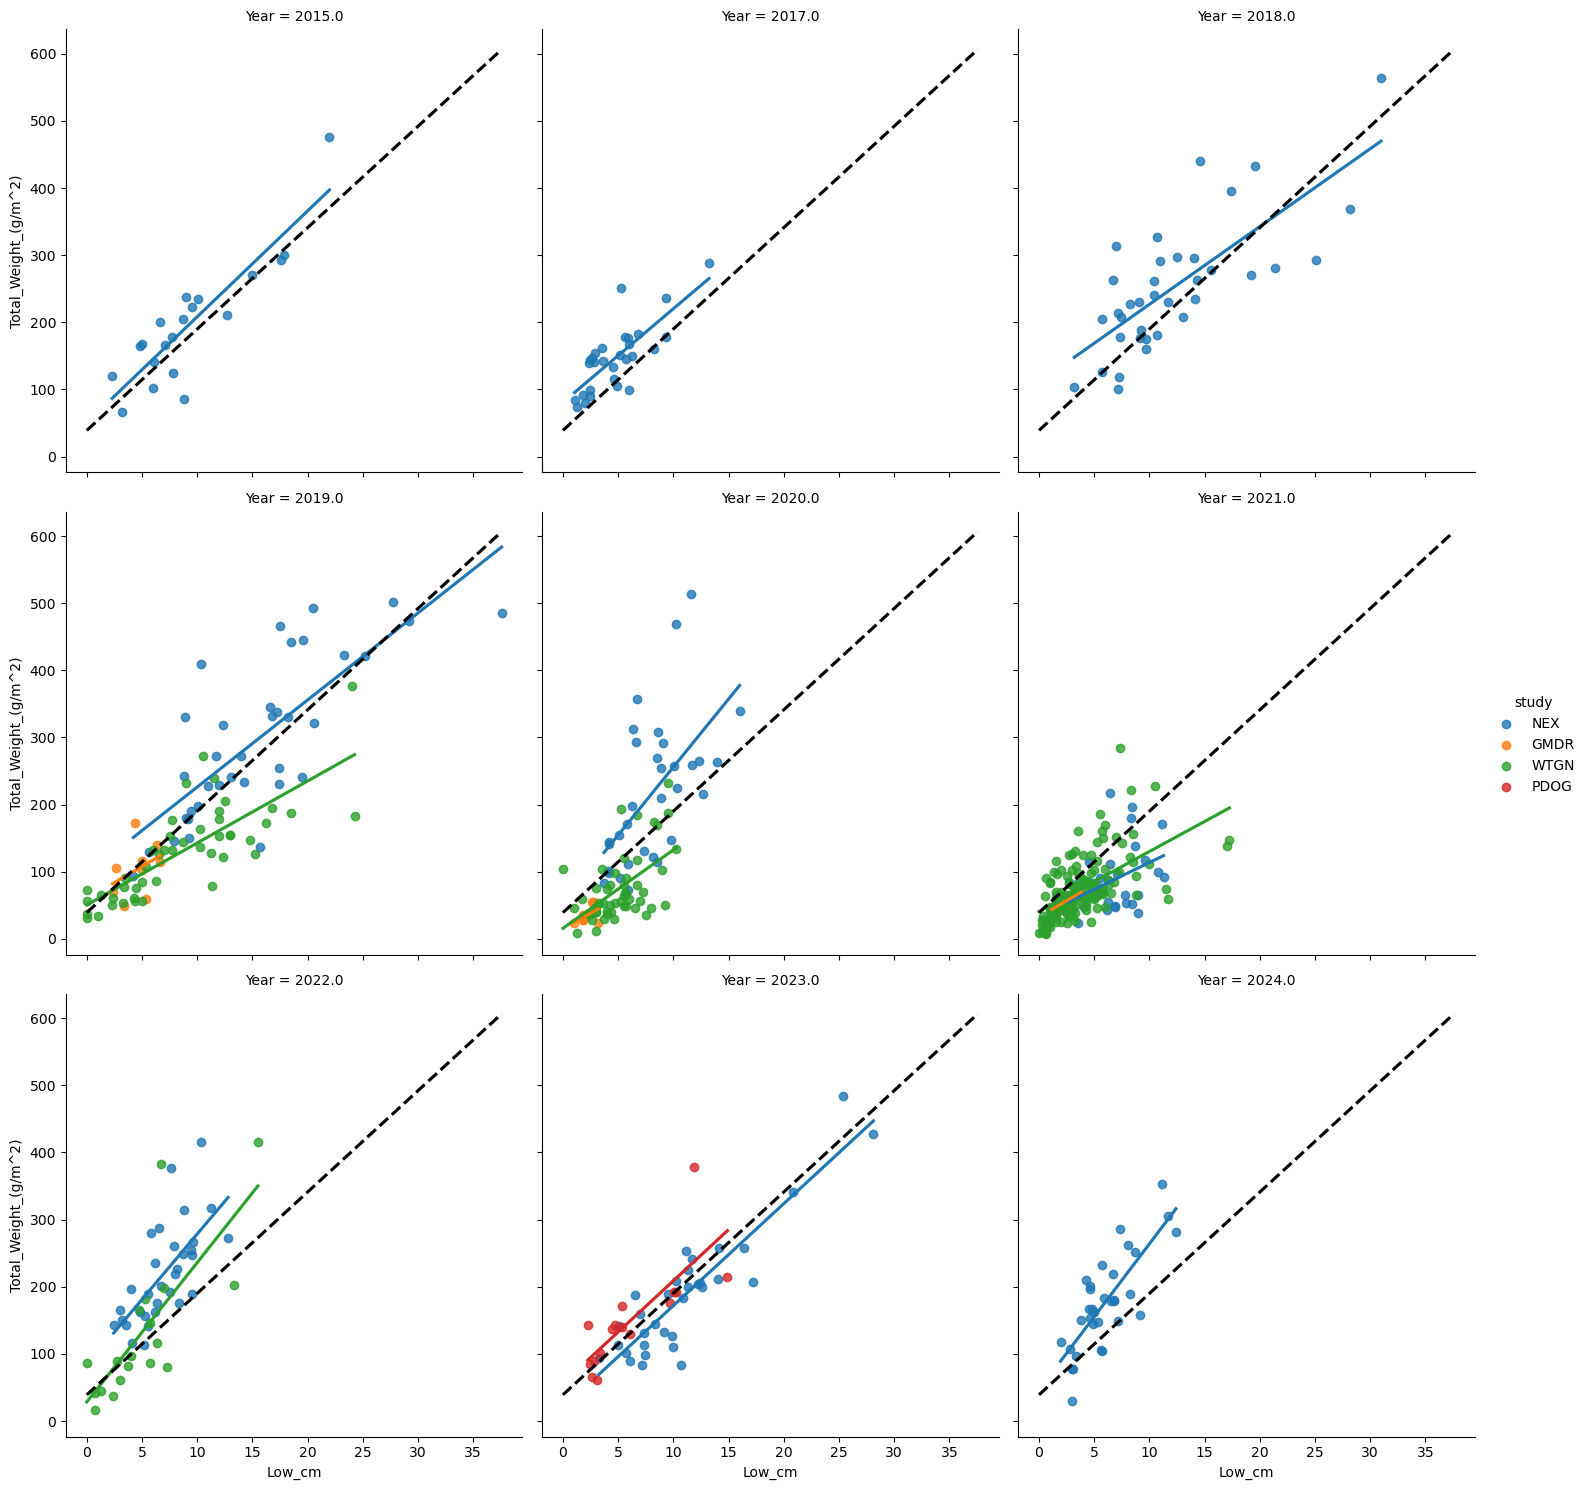

In [11]:
# plot VOR low vs Biomass by Year and study
p = sns.lmplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', hue='study', col='Year', col_wrap=3, ci=None)
for ax in p.axes.flatten():
    sns.regplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', scatter=False, 
                line_kws={'linestyle': 'dashed', 'color': 'black'}, ax=ax, ci=None, )

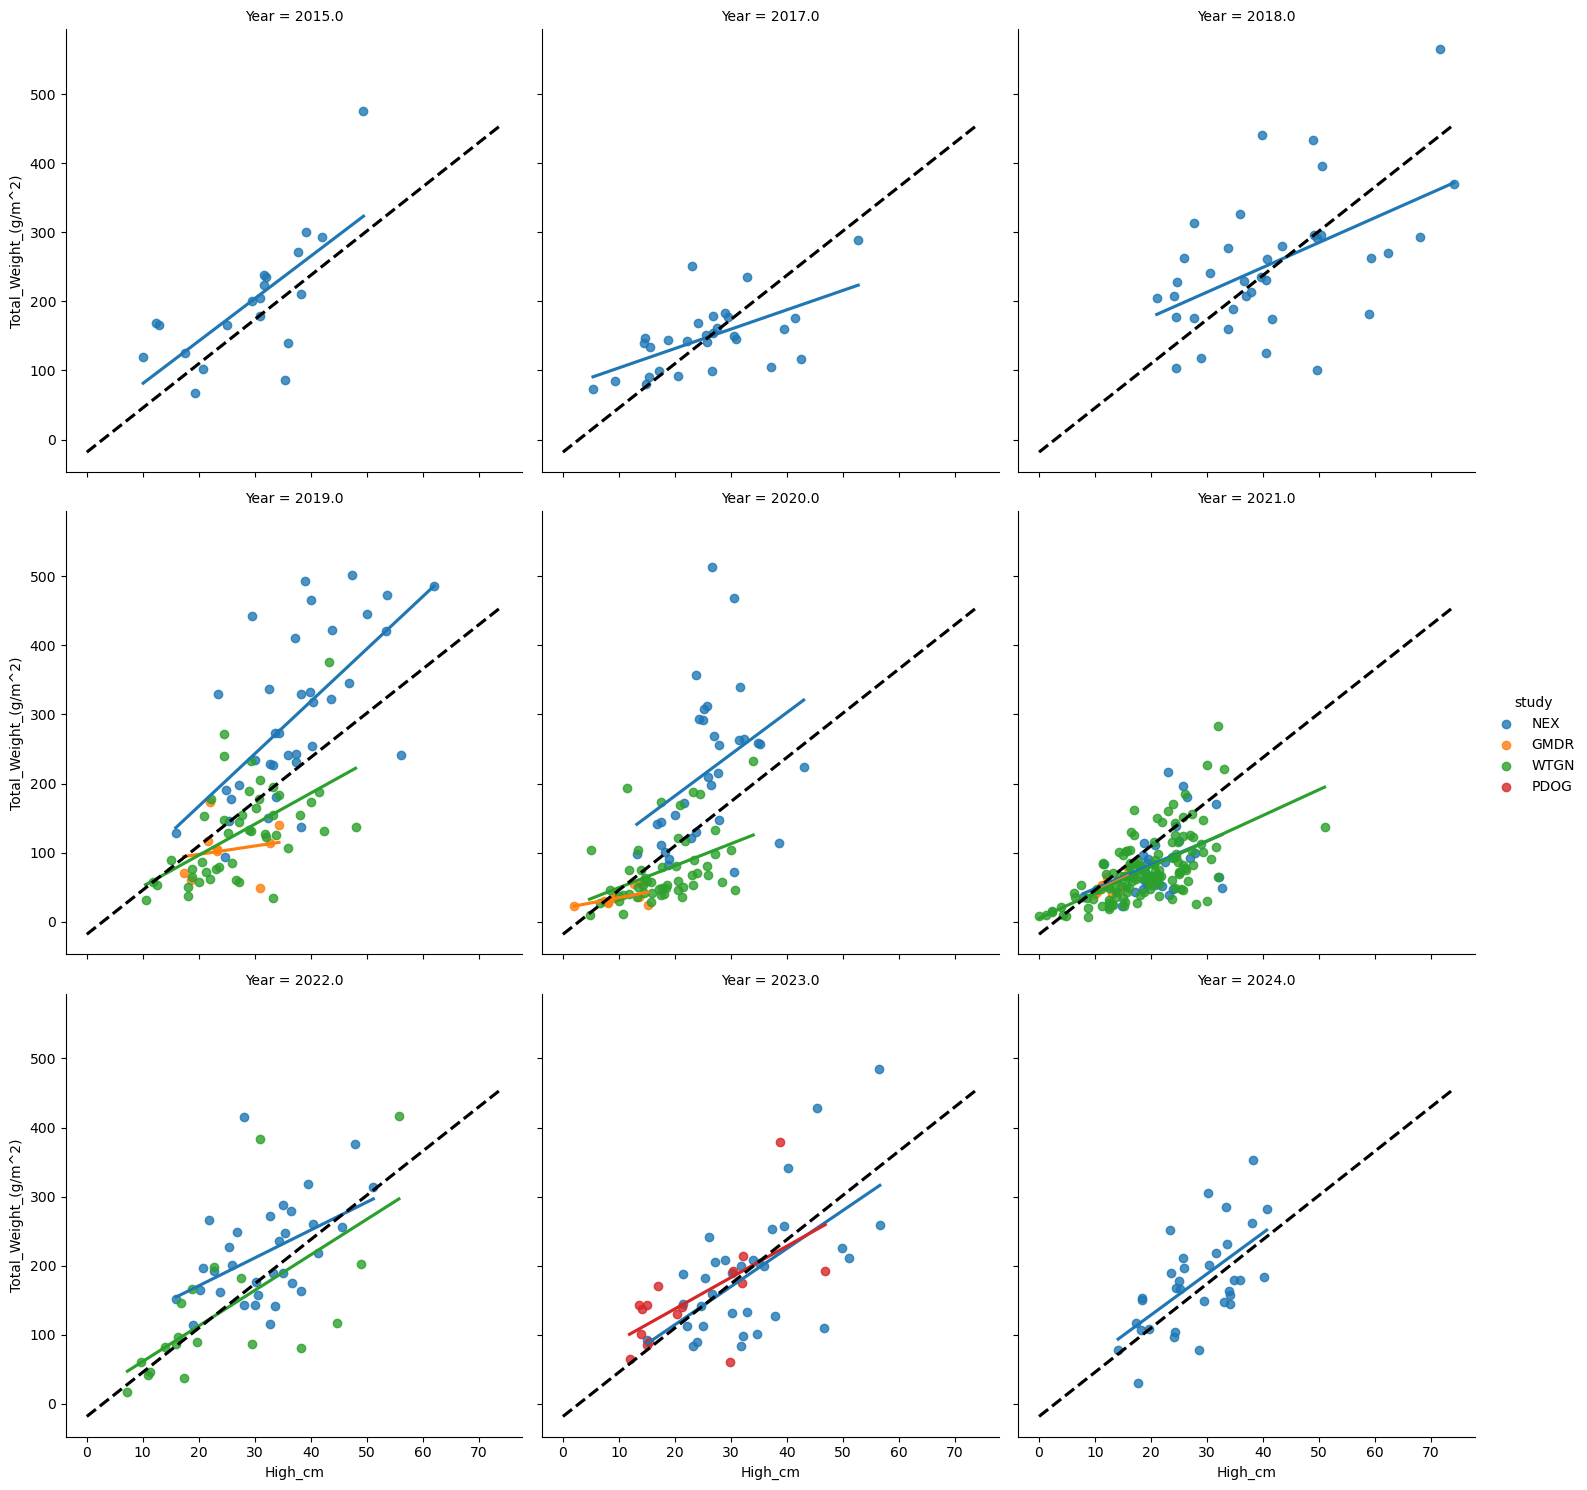

In [12]:
# plot VOR low vs Biomass by Year and study
p = sns.lmplot(data=df_vor, x='High_cm', y='Total_Weight_(g/m^2)', hue='study', col='Year', col_wrap=3, ci=None)
for ax in p.axes.flatten():
    sns.regplot(data=df_vor, x='High_cm', y='Total_Weight_(g/m^2)', scatter=False, 
                line_kws={'linestyle': 'dashed', 'color': 'black'}, ax=ax, ci=None, )

<AxesSubplot:xlabel='Low_cm', ylabel='Total_Weight_(g/m^2)'>

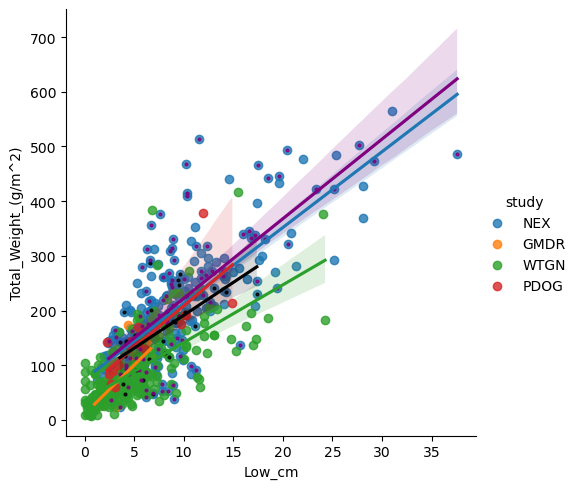

In [15]:
# plot VOR low vs. biomass by study across all years
p = sns.lmplot(data=df_vor, 
           hue='study',
           x='Low_cm', y='Total_Weight_(g/m^2)')
# add the lake creek site (which is spatially lumped with the WTGN sites) as a black line
# only for years where WTGN data available
sns.regplot(data=df_vor[(df_vor['Pasture'] == 'lake creek') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='Low_cm', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'black', 's': 4}, 
           line_kws={'color': 'black'},
            ax=p.ax)
# add the other NEX sites as a purple line
# only for years when WTGN available
sns.regplot(data=df_vor[(df_vor['Pasture'] != 'lake creek') &
                        (df_vor['study'] == 'NEX') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='Low_cm', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'purple', 's': 4}, 
           line_kws={'color': 'purple'},
            ax=p.ax)

<AxesSubplot:xlabel='Low_cm', ylabel='Total_Weight_(g/m^2)'>

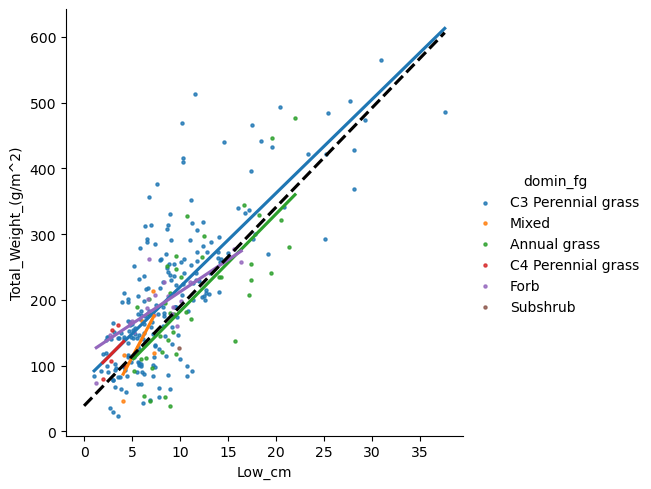

In [16]:
# plot VOR low vs. biomass by dominant functional group
# only done for NEX project, since dominant functional group has not been
# extracted for other projects yet
p = sns.lmplot(data=df_vor[df_vor['study'] == 'NEX'], 
               x='Low_cm', y='Total_Weight_(g/m^2)', hue='domin_fg', palette='tab10',
               scatter_kws={'s': 5}, ci=None)
sns.regplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', scatter=False, 
            line_kws={'linestyle': 'dashed', 'color': 'black'}, 
            ax=p.axes[0, 0], ci=None, )

<AxesSubplot:ylabel='Frequency'>

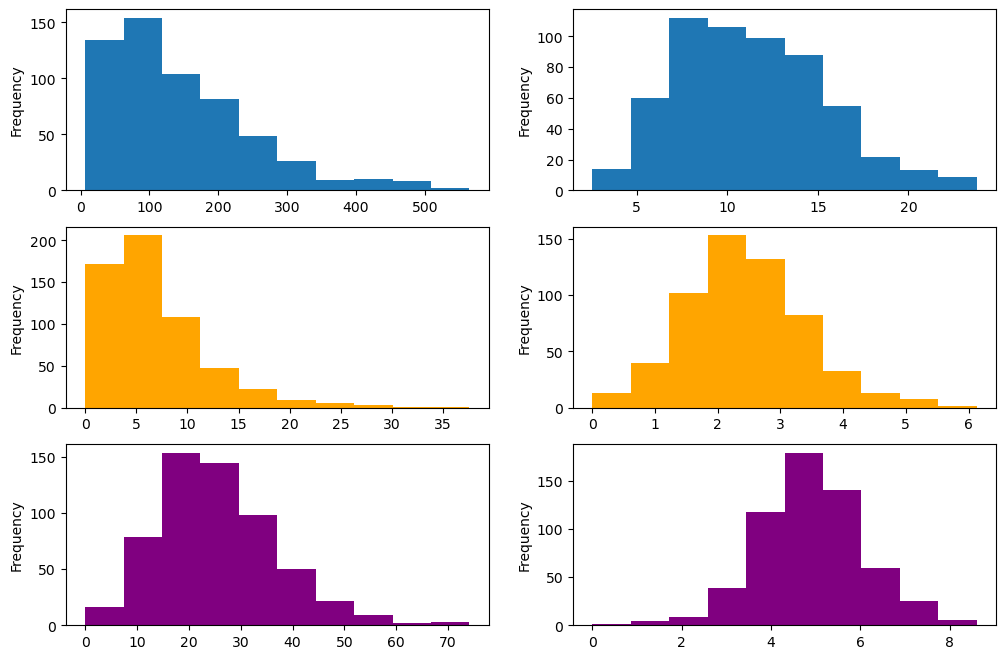

In [17]:
# compare transformed and orignal dependent and independent variables
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))
df_vor['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0, 0])
df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[0, 1])

df_vor['Low_cm'].plot.hist(ax=ax[1, 0], color='orange')
df_vor['Low_cm'].transform(lambda x:  np.power(x, 0.5)).plot.hist(ax=ax[1, 1], color='orange')

df_vor['High_cm'].plot.hist(ax=ax[2, 0], color='purple')
df_vor['High_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[2, 1], color='purple')

#### Predict biomass from VOR using the CPER model

In [32]:
import pickle
with open('./models/CPER_VOR_to_biomass_model_20240325.pk', 'rb') as f:
    cper_mod = pickle.load(f)

In [59]:
# predict using CPER coefficients, converting to g/m2
#df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10

# predict using CPER saved model, converting to g/m2
df_vor['pred_cper'] = cper_mod.predict(df_vor.rename(columns={'Low_cm': 'Low', 'High_cm': 'High'}))**2/10

# get residuals
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']

##### Compare CPER model predictions to the fitting the same model to data

In [60]:
# create an empty dataframe to populate
df_mod_results = pd.DataFrame(columns=['dataset', 'R2', 
                                       'TB_MAE', 'TB_MAE_pct',
                                       'CPER_MAE', 'CPER_MAE_pct'])

# loop through each study and refit the model
# then calculate R2, mean absolute error (MAE) and relative error (MAE_pct)
idx=0
for study, grp in df_vor.groupby('study'):
    mod_tmp = smf.ols("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", 
                   data=grp).fit()
    grp['pred_tb'] = mod_tmp.predict()
    grp['resid_tb'] = grp['pred_tb'] - grp['Total_Weight_(g/m^2)']
    mae_tmp = grp.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    mae_tmp_cper = grp.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    df_mod_results = pd.concat([df_mod_results, (pd.DataFrame({
        'dataset': study,
        'R2': round(mod_tmp.rsquared_adj, 2),
        'TB_MAE': mae_tmp,
        'TB_MAE_pct': round(mae_tmp / grp['Total_Weight_(g/m^2)'].mean() * 100, 2),
        'CPER_MAE': mae_tmp_cper,
        'CPER_MAE_pct': round(mae_tmp_cper / grp['Total_Weight_(g/m^2)'].mean() * 100, 2)},
    index=[idx]))])
    idx += 1

In [61]:
# print the results
df_mod_results

,dataset,R2,TB_MAE,TB_MAE_pct,CPER_MAE,CPER_MAE_pct
0,GMDR,0.56,15.428892,24.7,19.471729,31.18
1,NEX,0.57,51.506478,25.49,54.659609,27.05
2,PDOG,0.55,32.169191,21.3,39.528556,26.17
3,WTGN,0.5,31.220635,34.97,43.982056,49.27


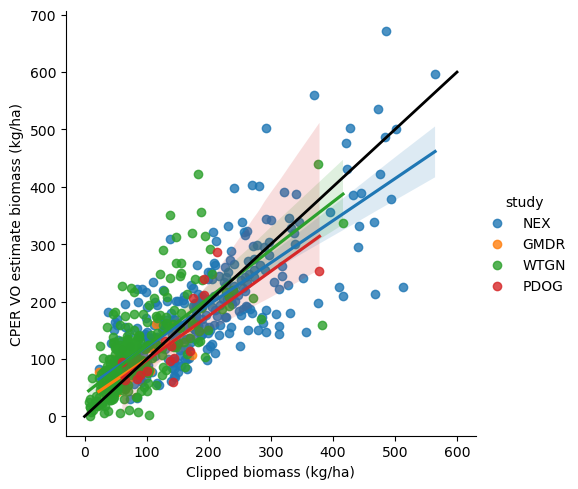

In [62]:
# plot the results of the CPER prediction by study
sns.lmplot(data=df_vor,
            y='pred_cper', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

#### Fit initial VOR model(s)

##### Additional data prep

In [63]:
# set whether to exclude the weight gain study in the model
exclude_wtgn=False
if exclude_wtgn:
    df_vor_mod = df_vor[df_vor['study'] != 'WTGN'].copy(deep=True)
else:
    df_vor_mod = df_vor.copy(deep=True)
    
# drop 2022 data because not fully QA/QC'd
drop_2022=False
if drop_2022:
    df_vor_mod = df_vor_mod[df_vor_mod['Year'] != 2022].copy()

# drop any data where clipped biomass was collected after VOR
drop_diff_days=False
if drop_diff_days:
    df_vor_mod = df_vor_mod[df_vor_mod['Date_diff_days'] <= 0]

In [64]:
if exclude_wtgn or drop_2022 or drop_diff_days:
    # compare transformed and orignal dependent and independent variables for subset data
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))
    df_vor_mod['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0, 0])
    df_vor_mod['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[0, 1])

    df_vor_mod['Low_cm'].plot.hist(ax=ax[1, 0], color='orange')
    df_vor_mod['Low_cm'].transform(lambda x:  np.power(x, 0.5)).plot.hist(ax=ax[1, 1], color='orange')

    df_vor_mod['High_cm'].plot.hist(ax=ax[2, 0], color='purple')
    df_vor_mod['High_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[2, 1], color='purple')

##### Fit models

In [65]:
# simple full model
form_simp = "Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm"
# full model, transform dependent variable
form_dx = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ Low_cm + High_cm"
# full model, transform dependent and independent variables
form_dx_ix = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5)"
# full model, transformed, and interactions
form_dx_ix_intx = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) * np.power(High_cm, 0.5)"

# fit all models
mod_simp = smf.ols(form_simp, data=df_vor_mod).fit()
mod_dx = smf.ols(form_dx, data=df_vor_mod).fit()
mod_dx_ix = smf.ols(form_dx_ix, data=df_vor_mod).fit()
mod_dx_ix_intx = smf.ols(form_dx_ix_intx, data=df_vor_mod).fit()

In [66]:
# calculate and save Adjusted R-Squared and Mean Absolute Error (relative to mean)
df_mods_out = pd.DataFrame({'form': ['Simple', 'DX', 'DX_IX', 'DX_IX_INTX'],
              'R-sq_adj': [round(mod_simp.rsquared_adj, 2),
                           round(mod_dx.rsquared_adj, 2),
                           round(mod_dx_ix.rsquared_adj, 2),
                           round(mod_dx_ix_intx.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_simp.predict() -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx_ix.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx_ix_intx.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2)]
                  })
df_mods_out

,form,R-sq_adj,MAE_pct
0,Simple,0.63,0.32
1,DX,0.62,0.33
2,DX_IX,0.64,0.32
3,DX_IX_INTX,0.64,0.32


In [67]:
# run everything for the low-only model version of the most parsimonious above model
# whic is to transform dependent and independent variables, no interactions
form_dx_ix_low = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5)"
mod_dx_ix_low = smf.ols(form_dx_ix_low, data=df_vor_mod).fit()
df_mods_out = pd.concat([df_mods_out, 
                       pd.DataFrame({'form': ['DX_IX_LOW'],
              'R-sq_adj': [round(mod_dx_ix_low.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_dx_ix_low.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2)]
                  })])
df_mods_out

,form,R-sq_adj,MAE_pct
0,Simple,0.63,0.32
1,DX,0.62,0.33
2,DX_IX,0.64,0.32
3,DX_IX_INTX,0.64,0.32
0,DX_IX_LOW,0.60,0.33


In [68]:
# check if most parsimonious full model is significantly different from low-only model
anova_lm(mod_dx_ix_low, mod_dx_ix)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,576.0,3870.776932,0.0,NaN,NaN,NaN
1,575.0,3503.607467,1.0,367.169465,60.258589,3.825592e-14


In [69]:
# print full summary of the simplest model
mod_simp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total_Weight_(g/m^2)')   R-squared:                       0.635
Model:                                   OLS   Adj. R-squared:                  0.633
Method:                        Least Squares   F-statistic:                     499.3
Date:                       Thu, 01 May 2025   Prob (F-statistic):          1.97e-126
Time:                               14:02:21   Log-Likelihood:                -3205.3
No. Observations:                        578   AIC:                             6417.
Df Residuals:                            575   BIC:                             6430.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8025      6.541      1.040      0.299      -6.045      19.650
Low_cm        11.0342      0.793     13.919      0.000       9.477      12.591
High_cm        2.3855      0.366      6.516      0.000       1.666       3.105
==============================================================================
Omnibus:                       91.112   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.848
Skew:                           0.829   Prob(JB):                     8.17e-48
Kurtosis:                       5.502   Cond. No.                         73.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# print full summary of the best model
mod_dx_ix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     np.power(Q('Total_Weight_(g/m^2)'), 0.5)   R-squared:                       0.641
Model:                                                  OLS   Adj. R-squared:                  0.640
Method:                                       Least Squares   F-statistic:                     513.4
Date:                                      Thu, 01 May 2025   Prob (F-statistic):          1.22e-128
Time:                                              14:02:22   Log-Likelihood:                -1340.9
No. Observations:                                       578   AIC:                             2688.
Df Residuals:                                           575   BIC:                             2701.
Df Model:                                                 2                                         
Covariance Type:                                  nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2073      0.470      0.441      0.659      -0.716       1.130
np.power(Low_cm, 0.5)      2.2131      0.178     12.419      0.000       1.863       2.563
np.power(High_cm, 0.5)     1.1496      0.148      7.763      0.000       0.859       1.440
==============================================================================
Omnibus:                        6.126   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.986
Skew:                           0.222   Prob(JB):                       0.0501
Kurtosis:                       3.228   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
# check normality of residuals
df_vor_mod['pred_tb'] = mod_dx_ix.predict()**2
df_vor_mod['resid_tb'] = df_vor_mod['pred_tb'] - df_vor_mod['Total_Weight_(g/m^2)']
shapiro(df_vor_mod['resid_tb'])

ShapiroResult(statistic=0.957233190536499, pvalue=6.5563023760040195e-12)

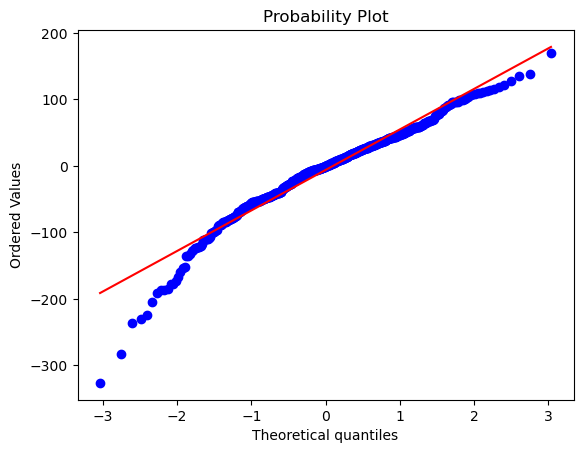

In [72]:
probplot(df_vor_mod['resid_tb'], dist="norm", plot=pylab)
pylab.show()

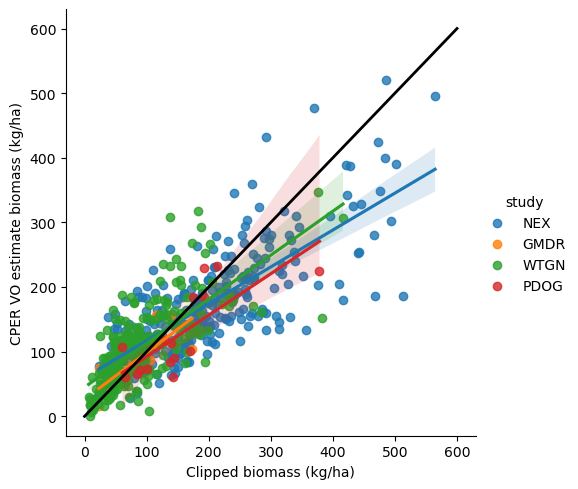

In [73]:
# plot the results of the TB prediction by study
sns.lmplot(data=df_vor_mod,
            y='pred_tb', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

MAE from TB model:  0.32
MAE from CPER model:  0.33


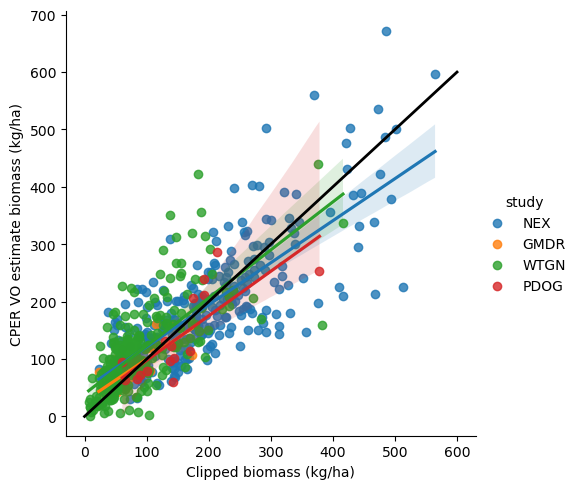

In [74]:
# compare to CPER model predictions
# plot the results of the CPER prediction by study
sns.lmplot(data=df_vor_mod,
            y='pred_cper', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')
# print the overall MAE_pct from both
print('MAE from TB model: ', df_mods_out[df_mods_out['form'] == 'DX_IX']['MAE_pct'].values[0])
print('MAE from CPER model: ', 
      round(np.mean(abs(
          df_vor_mod['pred_cper'] -
          df_vor_mod['Total_Weight_(g/m^2)']) / 
                    df_vor_mod['Total_Weight_(g/m^2)'].mean()), 2))

Text(43.17169704861111, 0.5, 'CPER VO estimate biomass (kg/ha)')

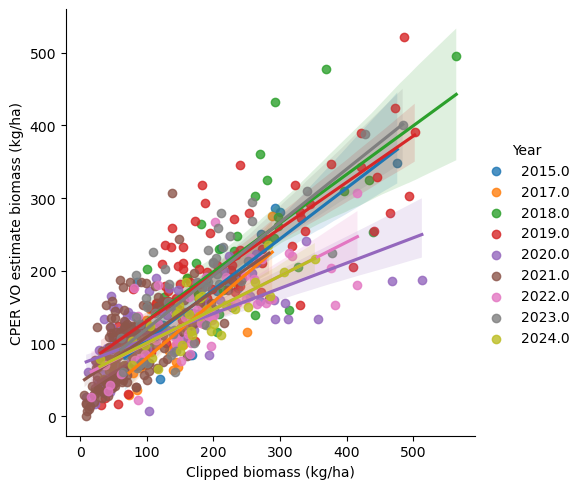

In [119]:
# plot the results of the TB prediction by year
sns.lmplot(data=df_vor_mod,
            y='pred_tb', x='Total_Weight_(g/m^2)',
           hue='Year')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

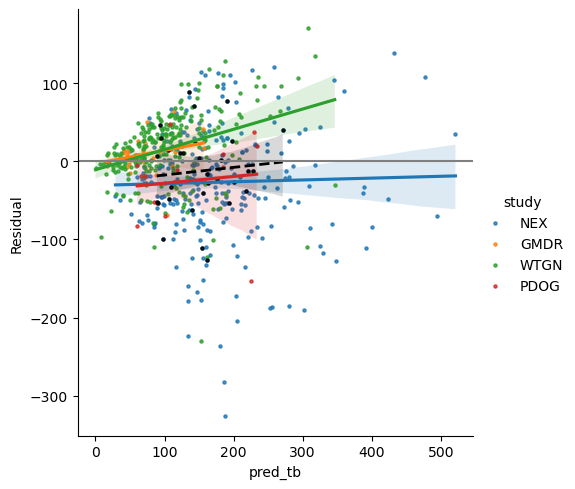

In [76]:
# plot residuals by study for TB model
p = sns.lmplot(y='resid_tb',
           x='pred_tb',
           hue='study',
           data=df_vor_mod,
          # line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'s': 5}
          )
sns.regplot(y='resid_tb',
           x='pred_tb',
           data=df_vor_mod[(df_vor_mod['Pasture'] == 'lake creek') &
                        (df_vor_mod['Year'].isin(df_vor_mod[df_vor_mod['study'] == 'WTGN']['Year'].unique()))],
          line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'color': 'black', 's': 5},
            ax=p.ax
          )
#plt.xlabel('VO estimate biomass (kg/ha)')
plt.ylabel('Residual')
plt.axhline(y=0, color='grey')

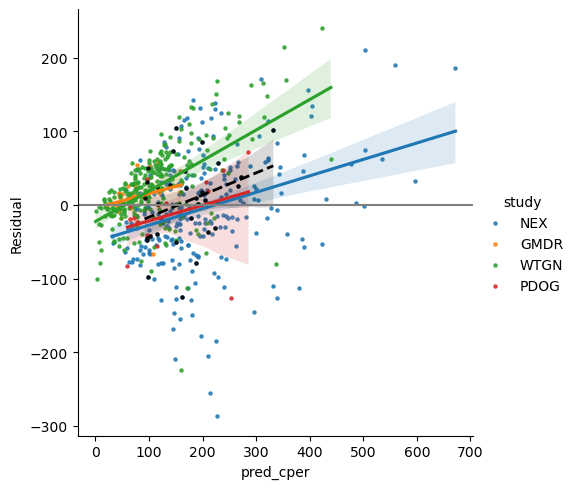

In [77]:
# plot residuals by study for CPER model
p = sns.lmplot(y='resid_cper',
           x='pred_cper',
           hue='study',
           data=df_vor_mod,
          # line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'s': 5}
          )
sns.regplot(y='resid_cper',
           x='pred_cper',
           data=df_vor_mod[(df_vor_mod['Pasture'] == 'lake creek') &
                        (df_vor_mod['Year'].isin(df_vor_mod[df_vor_mod['study'] == 'WTGN']['Year'].unique()))],
          line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'color': 'black', 's': 5},
            ax=p.ax
          )
#plt.xlabel('VO estimate biomass (kg/ha)')
plt.ylabel('Residual')
plt.axhline(y=0, color='grey')

#### Extract gridded PRISM data from Earth Engine 
This step may take a few minutes.

In [78]:
# drop any data points with location data
gdf_vor = gdf_vor[gdf_vor['Mean.GPS_E.Biomass'].notnull()].to_crs('EPSG:4269')
# convert date column to string
gdf_vor['Date'] = gdf_vor['Date'].dt.strftime('%Y-%m-%d')

In [113]:
#gdf_vor.Date.dt.year.unique()

In [79]:
# create an EE feature collection from the GeoDataFrame
fc_vor = ee.FeatureCollection(json.loads(gdf_vor[['Date', 'geometry']].to_json()))

# create an image collection of PRISM data from EE
ic_prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d')

# iteratively apply our custom function to each feature
fc_vor = fc_vor.map(get_prism_ppt)

# get the actually data from the EE server (this may take a few minutes)
collection = fc_vor.getInfo()

In [80]:
# combine the EE PRISM data with the original GeoDataFrame
gdf_vor = pd.merge(gdf_vor, 
                   gpd.GeoDataFrame.from_features(collection['features']),
                   how='left', 
                   on=['geometry', 'Date'])

# get the cumulative precip from last year and this year
gdf_vor['ppt_yr_cumsum'] = (gdf_vor['ppt_lag'] + gdf_vor['ppt_current']) * 0.0393701
# convert date string back to datetime format
gdf_vor['Date'] = pd.to_datetime(gdf_vor['Date'])

In [81]:
# add a unique plot ID to match the DataFrame
gdf_vor['id_plot'] = gdf_vor.apply(lambda x: '_'.join([x['Site'], x['Disturbance'], x['Exclosure']]) if x['study'] == 'NEX' else
                                   '_'.join([x['Pasture'], str(int(x['Plot']))]) if x['study'] == 'WTGN' else
                                   '_'.join([str(int(x['Block'])), str(int(x['Paddock']))]) if x['study'] == 'GMDR' else
                                   x['point'], axis=1)
# add a pasture (e.g., site/block) to match the DataFrame
gdf_vor['Pasture'] = gdf_vor.apply(lambda x: x['Pasture'] if x['study'] == 'WTGN' else
                                   x['Site'] if x['study'] != 'PDOG' else x['point'], axis=1)

<AxesSubplot:xlabel='Date', ylabel='ppt_yr_cumsum'>

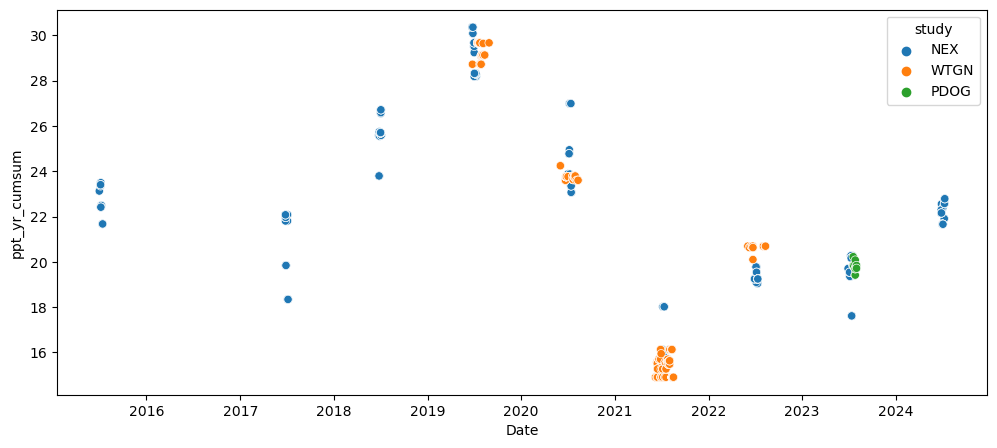

In [82]:
# plot cumulative precip by sampling date to look at variation over space/time
plt.figure(figsize=(12, 5))
sns.scatterplot(x='Date', y='ppt_yr_cumsum', hue='study', data=gdf_vor)

<AxesSubplot:>

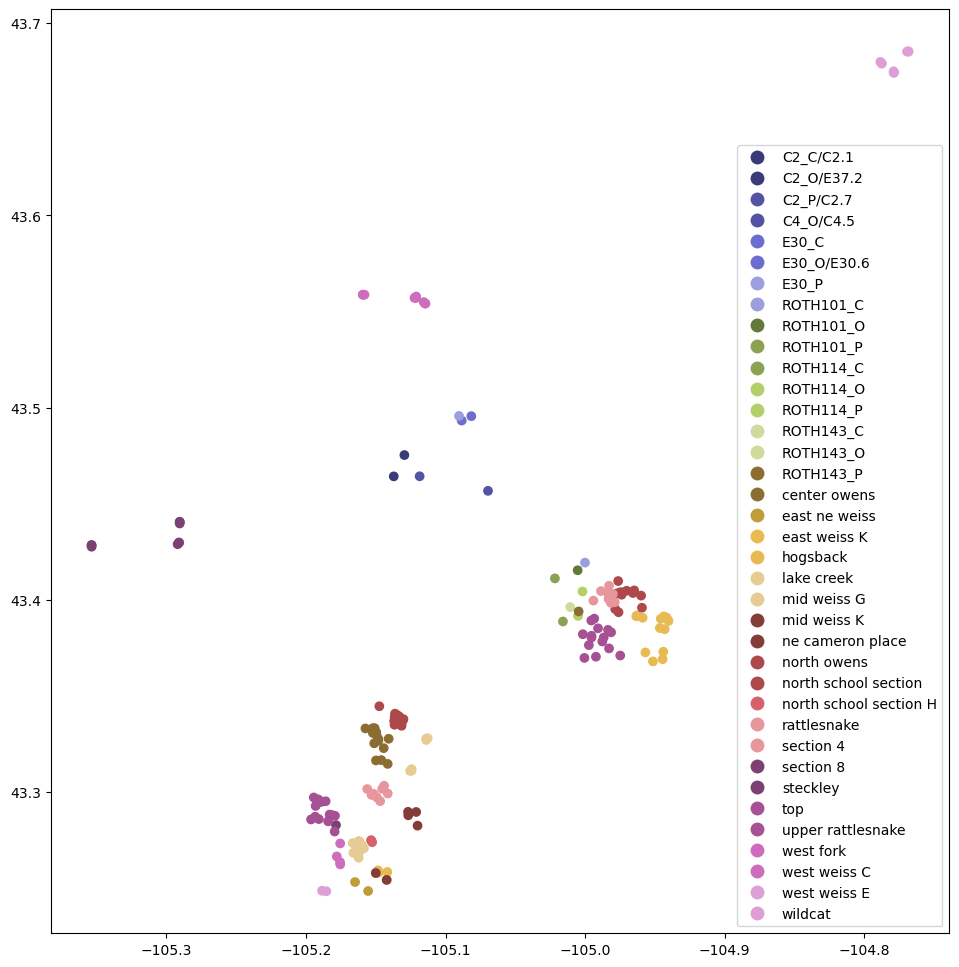

In [83]:
# create a map of the individual locations, by Pasture/site/block
fig,ax = plt.subplots(figsize=(12, 12))
gdf_vor.groupby('id_plot').first().reset_index().plot(column='Pasture', legend=True, ax=ax, cmap='tab20b')
#gdf_vor[gdf_vor['study'] == 'NEX'].groupby('id_plot').first().plot(ax=ax, color='black')

#### Merge with PRISM data and refit models

##### Additional data prep

In [84]:
# merge the universal PRISM data using a single point applied to all of TB
#df_vor = pd.merge_asof(df_vor.sort_values('Date'), 
#                       df_prism[['Date', 'ppt_yr_cumsum']],
#                       left_on='Date',
 #                      right_on='Date',
 #                      direction='nearest',
 #                      tolerance=timedelta(days=1),
 #                      suffixes=['_x', ''],)

# merge the gridded PRISM data, which extracted a unique precip value for each plot location
df_vor = pd.merge(df_vor,
                  gdf_vor[['Date', 'id_plot', 'ppt_yr_cumsum', 'ppt_lag', 'ppt_current']],
                  on=['Date', 'id_plot'])

In [85]:
df_vor

,Site,Disturbance,Exclosure,Date,Date_cln,Year,High_cm,Low_cm,Area_(m^2),Total_Weight_(g),...,geometry,id_plot,Date_diff,Date_diff_days,domin_fg_2,pred_cper,resid_cper,ppt_yr_cumsum,ppt_lag,ppt_current
0,lake creek,control,livestock ex,2017-07-04,2017-07-25,2017.0,26.555556,5.944444,0.5,49.796667,...,POINT (490771.572 4797154.182),lake creek_control_livestock ex,-21 days,-21.0,Mixed,139.599786,40.006453,22.075445,355.380002,205.336001
1,lake creek,control,livestock ex,2018-07-03,2018-07-03,2018.0,37.891892,7.135135,0.1,21.416667,...,POINT (490771.572 4797154.182),lake creek_control_livestock ex,0 days,0.0,Mixed,175.659457,-38.507210,26.586156,385.366002,289.922001
2,lake creek,control,livestock ex,2019-07-01,2019-07-01,2019.0,33.714286,8.942857,0.1,18.066667,...,POINT (490771.572 4797154.182),lake creek_control_livestock ex,0 days,0.0,Annual grass,198.485041,17.818375,29.505449,524.925001,224.513000
3,lake creek,control,livestock ex,2020-07-01,2020-07-01,2020.0,30.611111,5.916667,0.1,7.236667,...,POINT (490771.572 4797154.182),lake creek_control_livestock ex,0 days,0.0,Mixed,145.117597,72.750930,23.872493,475.447001,130.914000
4,lake creek,control,livestock ex,2021-07-08,2021-07-08,2021.0,23.942857,6.914286,0.1,4.673333,...,POINT (490771.572 4797154.182),lake creek_control_livestock ex,0 days,0.0,Mixed,150.851296,104.117962,15.801335,261.419000,139.934697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,NaN,NaN,NaN,2023-07-27,NaN,2023.0,29.894737,3.105263,NaN,NaN,...,POINT (493406.200 4815853.740),E30_O/E30.6,NaT,NaN,NaN,95.408177,34.489177,20.077562,318.732292,191.237495
574,NaN,NaN,NaN,2023-07-27,NaN,2023.0,30.450000,10.100000,NaN,NaN,...,POINT (492849.640 4815598.560),E30_C,NaT,NaN,NaN,210.951176,18.635176,19.693349,318.174292,182.036497
575,NaN,NaN,NaN,2023-07-27,NaN,2023.0,11.900000,2.650000,NaN,NaN,...,POINT (492695.410 4815866.000),E30_P,NaT,NaN,NaN,63.824643,-1.305357,19.693349,318.174292,182.036497
576,NaN,NaN,NaN,2023-08-01,NaN,2023.0,31.947368,9.684211,NaN,NaN,...,POINT (499567.700 4806948.900),ROTH101_O,NaT,NaN,NaN,207.130919,31.698919,19.839148,309.134292,194.779795


In [86]:
# create new variables from the single-point PRISM data
df_prism['ppt_yr_cumsum'] = df_prism['ppt (inches)'].rolling(window=365+240).sum()
df_prism['ppt_120_cumsum'] = df_prism['ppt (inches)'].rolling(window=120).sum()
df_prism['temp_month_avg'] = df_prism['tmax (degrees F)'].rolling(window=30, center=True).mean()

In [111]:
#df_prism

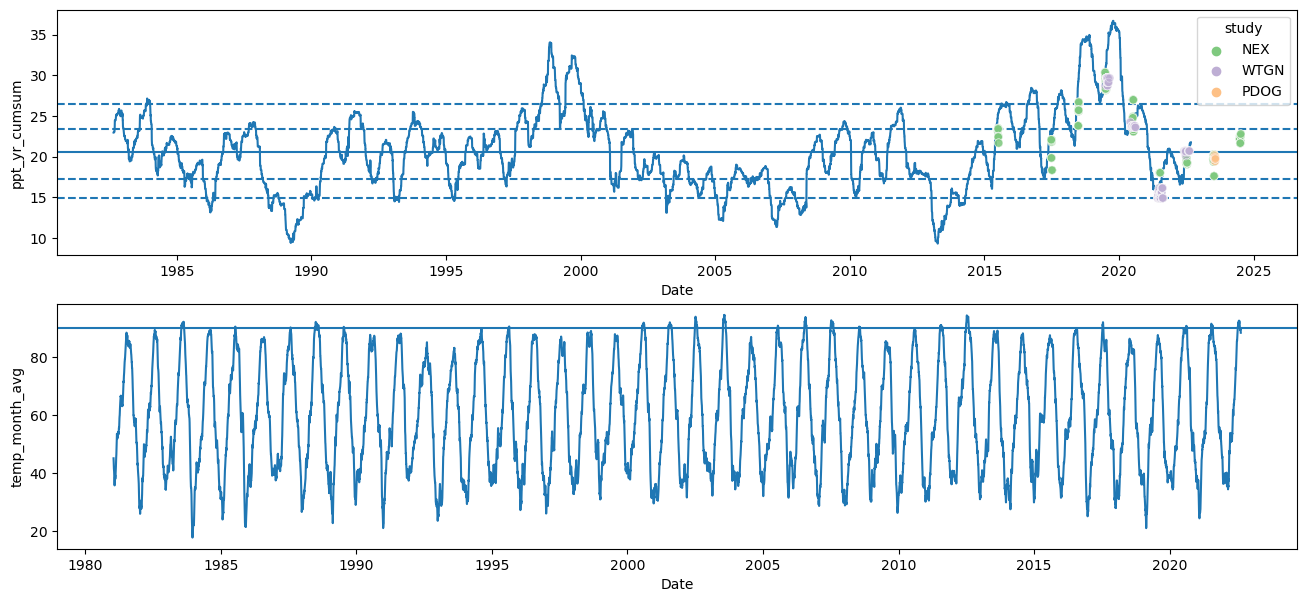

In [87]:
# plot single point PRISM data (lines) overlayed with the grid-based plot PRISM data (points)
# NOTE: this is not an 'apples-to-apples' comparison since cumulative precip is not calculated
# exactly the same way in the two datasets
fig, axs = plt.subplots(nrows=2, figsize=(16, 7))
sns.lineplot(data=df_prism, x='Date', y='ppt_yr_cumsum', ax=axs[0])
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].mean())
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.25), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.75), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.1), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.9), linestyle='dashed')
sns.scatterplot(x='Date', y='ppt_yr_cumsum', data=gdf_vor, 
                ax=axs[0], hue='study', palette='Accent', zorder=10, alpha=0.5)

# plot temperature from the sinlge-point PRISM data
sns.lineplot(data=df_prism, x='Date', y='temp_month_avg', ax=axs[1])
axs[1].axhline(y=90)

In [88]:
# create bins of long-term cumulative precip based on single-point PRISM data
ppt_bins = [0,
            #df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.1), 
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.25),
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.75), 
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.9),
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].max()*1.01]

df_vor['ppt_binned'] = pd.cut(df_vor['ppt_yr_cumsum'], ppt_bins)

In [89]:
# create bins of cumulative precip based on plot PRISM data
ppt_yr_bins = [0,
               df_vor['ppt_yr_cumsum'].quantile(.1),
               df_vor['ppt_yr_cumsum'].quantile(.25),
               df_vor['ppt_yr_cumsum'].quantile(.75), 
               df_vor['ppt_yr_cumsum'].quantile(.9),
               df_vor['ppt_yr_cumsum'].max()*1.01]
df_vor['ppt_yr_binned'] = pd.cut(df_vor['ppt_yr_cumsum'], ppt_yr_bins)

# create bins of lagged (last year's) precip based on plot PRISM data
ppt_lag_bins = [0,
                df_vor['ppt_lag'].quantile(.1),
                df_vor['ppt_lag'].quantile(.25),
                df_vor['ppt_lag'].quantile(.75), 
                df_vor['ppt_lag'].quantile(.9),
                df_vor['ppt_lag'].max()*1.01]
df_vor['ppt_lag_binned'] = pd.cut(df_vor['ppt_lag'], ppt_lag_bins)

# create bins of current year precip based on plot PRISM data
ppt_current_bins = [0,
                    df_vor['ppt_current'].quantile(.1),
                    df_vor['ppt_current'].quantile(.25),
                    df_vor['ppt_current'].quantile(.75), 
                    df_vor['ppt_current'].quantile(.9),
                    df_vor['ppt_current'].max()*1.01]

df_vor['ppt_current_binned'] = pd.cut(df_vor['ppt_current'], ppt_current_bins)

In [90]:
# check how many observation are in each bin for long-term bins
# NOTE: had probably lump lowest two bins (remove .1 quantile above) since
# there wer no observations in the lowest bin using 5
df_vor['ppt_binned'].value_counts()

(0.0, 17.73]        194
(17.73, 23.22]      181
(23.22, 26.251]     103
(26.251, 35.613]    100
Name: ppt_binned, dtype: int64

In [91]:
# check how many observation are in each bin for current year
df_vor['ppt_yr_binned'].value_counts()

(15.949, 23.789]    292
(23.789, 28.831]     81
(14.907, 15.949]     79
(0.0, 14.907]        68
(28.831, 30.657]     58
Name: ppt_yr_binned, dtype: int64

In [92]:
# create bins for high VOR reading as a possible categorical co-variate?
high_bins = [0,
             #df_vor['High_cm'].quantile(0.1),
            df_vor['High_cm'].quantile(0.25),
            #df_vor['High_cm'].quantile(0.4),
            #df_vor['High_cm'].quantile(0.6),
            df_vor['High_cm'].quantile(0.75),
             #df_vor['High_cm'].quantile(0.9),
            df_vor['High_cm'].max()+1]
df_vor['High_cm_binned'] = pd.cut(df_vor['High_cm'], high_bins)

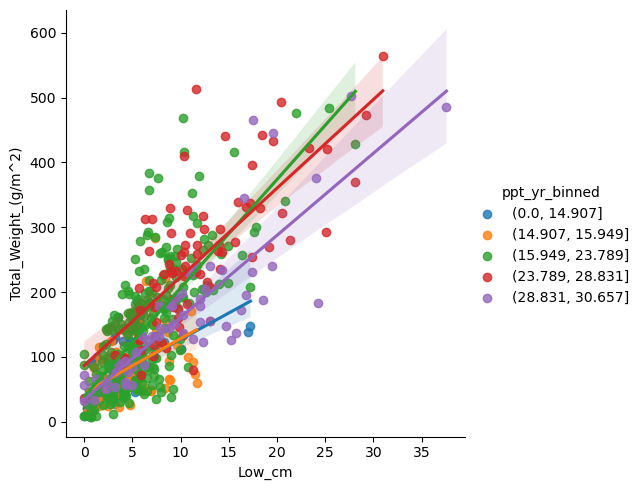

In [93]:
# plot relationship between low VOR and biomass by long-term precip bin
p = sns.lmplot(data=df_vor, 
           hue='ppt_yr_binned',
           x='Low_cm', 
               y='Total_Weight_(g/m^2)', order=1)

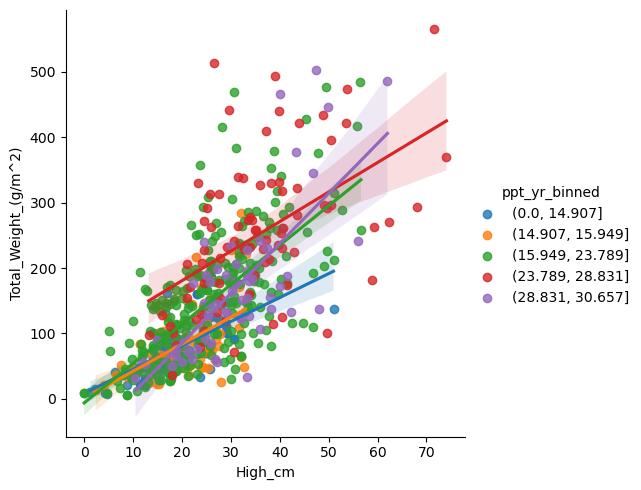

In [94]:
# plot relationship between low VOR and biomass by long-term precip bin
p = sns.lmplot(data=df_vor, 
           hue='ppt_yr_binned',
           x='High_cm', 
               y='Total_Weight_(g/m^2)', order=1)

<AxesSubplot:xlabel='ppt_yr_cumsum', ylabel='Total_Weight_(g/m^2)'>

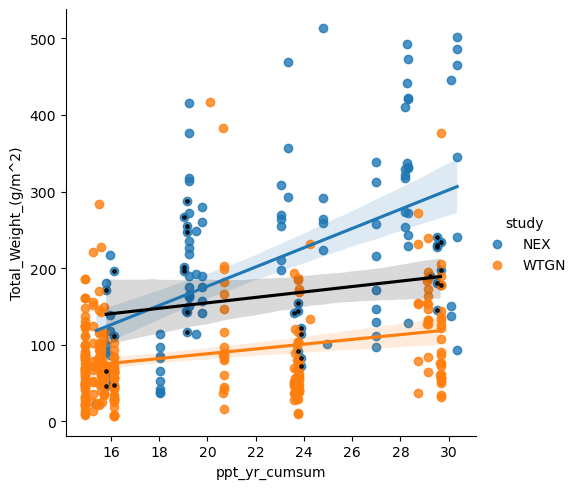

In [95]:
# plot relationship between cumulative precip and biomass by project
p = sns.lmplot(data=df_vor[df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique())], 
           hue='study',
           x='ppt_yr_cumsum', y='Total_Weight_(g/m^2)')
sns.regplot(data=df_vor[(df_vor['Pasture'] == 'lake creek') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='ppt_yr_cumsum', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'black', 's': 6}, 
           line_kws={'color': 'black'},
            ax=p.ax)

In [96]:
# subset data for modeling
if exclude_wtgn:
    df_vor_mod2 = df_vor[df_vor['study'] != 'WTGN'].copy(deep=True)
else:
    df_vor_mod2 = df_vor.copy(deep=True)
    
# drop 2022 data because not fully QA/QC'd
if drop_2022:
    df_vor_mod2 = df_vor_mod2[df_vor_mod2['Year'] != 2022].copy()

# drop any data where clipped biomass was collected after VOR
if drop_diff_days:
    df_vor_mod2 = df_vor_mod2[df_vor_mod2['Date_diff_days'] <= 0]

##### Fit models with precip

In [97]:
# adapt the best model above by adding different precip co-variates

# long-term average precip
form_lta = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_binned"
# cumulative precip of lag + current year
form_cum = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_yr_binned"
# lagged precip
form_lag = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_lag_binned"
# current year precip
form_cur = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_current_binned"

# fit all models
mod_lta = smf.ols(form_lta, data=df_vor_mod2).fit()
mod_cum = smf.ols(form_cum, data=df_vor_mod2).fit()
mod_lag = smf.ols(form_lag, data=df_vor_mod2).fit()
mod_cur = smf.ols(form_cur, data=df_vor_mod2).fit()

In [98]:
# calculate and save Adjusted R-Squared and Mean Absolute Error (relative to mean)
df_mods_out2 = pd.DataFrame({'form': ['LTA', 'CUM', 'LAG', 'CUR'],
              'R-sq_adj': [round(mod_lta.rsquared_adj, 2),
                           round(mod_cum.rsquared_adj, 2),
                           round(mod_lag.rsquared_adj, 2),
                           round(mod_cur.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_lta.predict() -
                      df_vor_mod2['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod2['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_cum.predict()**2 -
                      df_vor_mod2['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod2['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_lag.predict()**2 -
                      df_vor_mod2['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod2['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_cur.predict()**2 -
                      df_vor_mod2['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod2['Total_Weight_(g/m^2)'].mean(), 2)]
                  })
df_mods_out2

,form,R-sq_adj,MAE_pct
0,LTA,0.68,0.92
1,CUM,0.67,0.30
2,LAG,0.66,0.30
3,CUR,0.68,0.30


In [99]:
# check if the best precip model is different from the most parsimonious model above
anova_lm(mod_dx_ix, mod_cur)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,575.0,3503.607467,0.0,NaN,NaN,NaN
1,571.0,3081.677130,4.0,421.930337,19.544733,4.348613e-15


In [100]:
# check normality of residuals
df_vor_mod2['pred_tb_w_ppt'] = mod_cur.predict()**2
df_vor_mod2['resid_tb_w_ppt'] = df_vor_mod2['pred_tb_w_ppt'] - df_vor_mod2['Total_Weight_(g/m^2)']
shapiro(df_vor_mod2['resid_tb_w_ppt'])

ShapiroResult(statistic=0.9416160583496094, pvalue=2.728254328997117e-14)

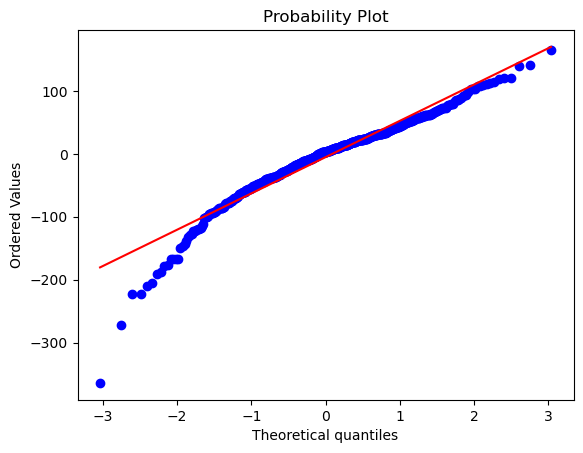

In [101]:
probplot(df_vor_mod2['resid_tb_w_ppt'], dist="norm", plot=pylab)
pylab.show()

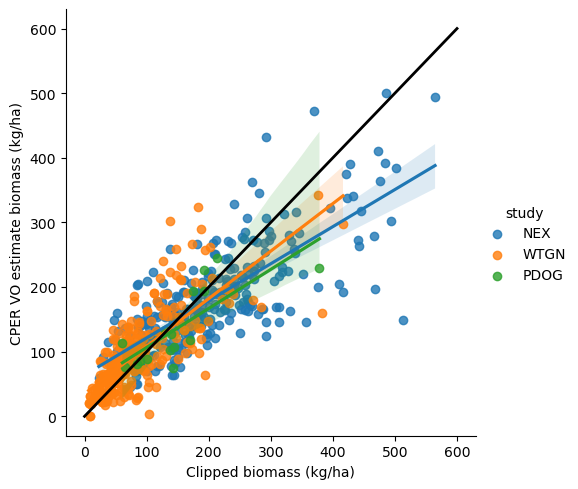

In [102]:
# plot the results of the TB prediction with precip by study
sns.lmplot(data=df_vor_mod2,
            y='pred_tb_w_ppt', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

MAE from TB precip model:  0.3
MAE from TB model:  0.32


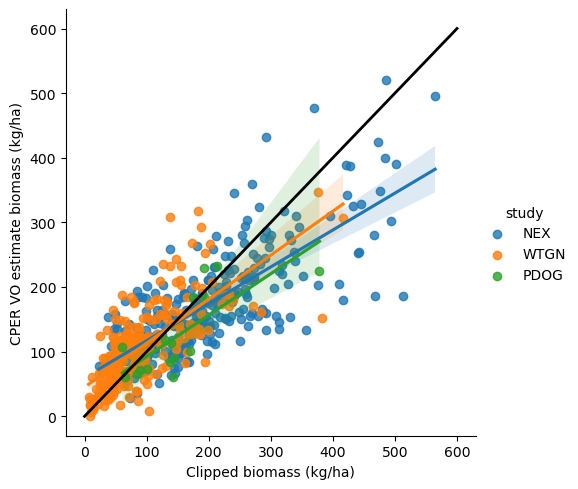

In [103]:
# compare to most parsimonious TB model predictions

# get subset of original data that have precip available
df_vor_mod_sub = df_vor_mod[df_vor_mod['study'].isin(df_vor_mod2['study'].unique())]

# plot the results of the TB prediction by study, only for studies with precip
sns.lmplot(data=df_vor_mod_sub,
            y='pred_tb', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')
# print the overall MAE_pct from both
print('MAE from TB precip model: ', df_mods_out2[df_mods_out2['form'] == 'CUR']['MAE_pct'].values[0])
print('MAE from TB model: ', 
      round(np.mean(df_vor_mod_sub.apply(
          lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']) / 
          df_vor_mod_sub['Total_Weight_(g/m^2)'].mean(),
      axis=1)), 2))

In [104]:
mod_cur.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     np.power(Q('Total_Weight_(g/m^2)'), 0.5)   R-squared:                       0.685
Model:                                                  OLS   Adj. R-squared:                  0.682
Method:                                       Least Squares   F-statistic:                     207.2
Date:                                      Thu, 01 May 2025   Prob (F-statistic):          9.33e-140
Time:                                              14:18:27   Log-Likelihood:                -1303.8
No. Observations:                                       578   AIC:                             2622.
Df Residuals:                                           571   BIC:                             2652.
Df Model:                                                 6                                         
Covariance Type:                                  nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.0632      0.509      0.124      0.901      -0.936       1.063
ppt_current_binned[T.Interval(132.85, 139.002, closed='right')]      0.2782      0.386      0.720      0.472      -0.481       1.037
ppt_current_binned[T.Interval(139.002, 205.414, closed='right')]     2.2584      0.334      6.761      0.000       1.602       2.914
ppt_current_binned[T.Interval(205.414, 236.058, closed='right')]     2.0552      0.403      5.098      0.000       1.263       2.847
ppt_current_binned[T.Interval(236.058, 298.59, closed='right')]      2.7389      0.464      5.898      0.000       1.827       3.651
np.power(Low_cm, 0.5)                                                2.2830      0.169     13.511      0.000       1.951       2.615
np.power(High_cm, 0.5)                                               0.7929      0.144      5.489      0.000       0.509       1.077
==============================================================================
Omnibus:                       26.807   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.619
Skew:                           0.452   Prob(JB):                     8.26e-08
Kurtosis:                       3.732   Cond. No.                         41.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
# check for interaction

# create formula with interaction
form_cur_intx = form_cur + " + ppt_current_binned:np.power(Low_cm, 0.5)"

# fit model
mod_cur_intx = smf.ols(form_cur_intx, data=df_vor_mod2).fit()

# add model results to dataframe
df_mods_out2 = pd.concat([df_mods_out2, 
                       pd.DataFrame({'form': ['CUR_INTX'],
              'R-sq_adj': [round(mod_cur_intx.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_cur_intx.predict()**2 -
                      df_vor_mod2['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod2['Total_Weight_(g/m^2)'].mean(), 2)]
                  })])
df_mods_out2

,form,R-sq_adj,MAE_pct
0,LTA,0.68,0.92
1,CUM,0.67,0.30
2,LAG,0.66,0.30
3,CUR,0.68,0.30
0,CUR_INTX,0.69,0.29


In [106]:
# check if the interaction model is different from the best precip model
anova_lm(mod_cur, mod_cur_intx)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,571.0,3081.677130,0.0,NaN,NaN,NaN
1,567.0,2971.505009,4.0,110.17212,5.255552,0.000367


In [107]:
# check normality of residuals
df_vor_mod2['pred_tb_w_ppt_fnl'] = mod_cur_intx.predict()**2
df_vor_mod2['resid_tb_w_ppt_fnl'] = df_vor_mod2['pred_tb_w_ppt_fnl'] - df_vor_mod2['Total_Weight_(g/m^2)']
shapiro(df_vor_mod2['resid_tb_w_ppt_fnl'])

ShapiroResult(statistic=0.9395884275436401, pvalue=1.4455376186415375e-14)

MAE from best TB precip model:  0.29
MAE from TB model:  0.32


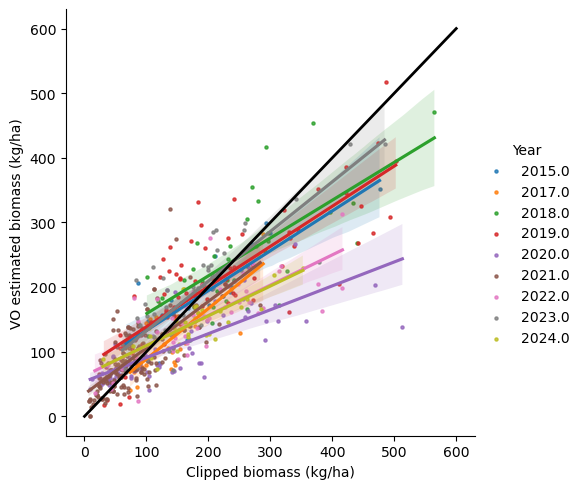

In [108]:
sns.lmplot(y='pred_tb_w_ppt_fnl',
           x='Total_Weight_(g/m^2)',
           data=df_vor_mod2,
           hue='Year',
           #line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
           #scatter_kws={'color': 'black', 's': 5}
           scatter_kws={'s': 5}
          )
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('VO estimated biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')
# print the overall MAE_pct from both
print('MAE from best TB precip model: ', df_mods_out2[df_mods_out2['form'] == 'CUR_INTX']['MAE_pct'].values[0])
print('MAE from TB model: ', 
      round(np.mean(df_vor_mod_sub.apply(
          lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']) / 
          df_vor_mod_sub['Total_Weight_(g/m^2)'].mean(),
      axis=1)), 2))

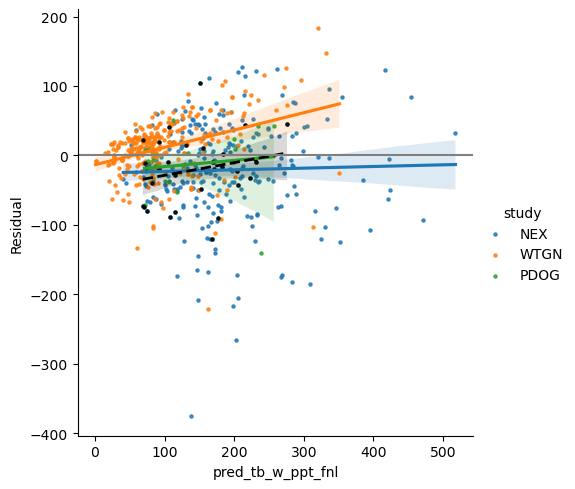

In [109]:
# plot residuals by study
p = sns.lmplot(y='resid_tb_w_ppt_fnl',
           x='pred_tb_w_ppt_fnl',
           hue='study',
           data=df_vor_mod2,
          # line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'s': 5}
          )
sns.regplot(y='resid_tb_w_ppt_fnl',
           x='pred_tb_w_ppt_fnl',
           data=df_vor_mod2[(df_vor_mod2['Pasture'] == 'lake creek') &
                        (df_vor_mod2['Year'].isin(df_vor_mod2[df_vor_mod2['study'] == 'WTGN']['Year'].unique()))],
          line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'color': 'black', 's': 5},
            ax=p.ax
          )
#plt.xlabel('VO estimate biomass (kg/ha)')
plt.ylabel('Residual')
plt.axhline(y=0, color='grey')

### Save the best model to disk for future application

In [118]:
import pickle
with open('models/vor_linreg_dx_ix_20250506.pk', 'wb') as f:
    pickle.dump(mod_dx_ix, f)